# Deutsch-Jozsa Algorithm for N-qubits

In [1]:
#=============================================================================#
#                            Importing packages                               #
#=============================================================================#
import numpy as np
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.providers.ibmq import least_busy 
provider = IBMQ.load_account()
from qiskit.visualization import plot_histogram


In [2]:
#=============================================================================#
#                                  Functions                                  #
#=============================================================================#
def oracle(case,n):
    '''
    Inputs:
    -------
    param case: (str) Indicate the type of function the oracle has to build
    param n: (int) Number of digits of our input
    Output:
    -------
    Oracle circuit that generate a constant or balanced function    
    '''
    # The oracle contains n-qubits of the input plus
    # one extra qubit usually known as control qubit (ancilla)
    oracle_qc = QuantumCircuit(n+1)

    if case == "balanced":
        # CNOT gate to all the inputs
        # First N-qubits: 0 to N-1 (range(n))
        # cx(control qubit,Target qubit Y)
        for qubit in range(n): 
            oracle_qc.cx(qubit,n)
    
    if case == "constant":
        # We want the outputs to be 00..000
        oracle_qc.x(n)
    
    # New Gate: Black Box
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = 'Oracle'
    return oracle_gate


def dj_algorithm(n, case = "random"):
    dj_circuit = QuantumCircuit(n+1,n) # Inputs: n+1 ; Outputs: n

    # Apply Hadamard gate to each qubit:
    for qubit in range(n):
        dj_circuit.h(qubit)

    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)

    # Append the oracle gate:
    if case == "random":
        random = np.random.randint(2)
        if random == 0:
            case = "constant"
        else:
            case = "balanced"

    dj_oracle = oracle(case,n)
    dj_circuit.append(dj_oracle, range(n+1))

    # Hadamard gate and measure:
    for i in range(n):
        dj_circuit.h(i)
        dj_circuit.measure(i,i) # Measure qubit 'i' 
                                # and store the measure in bit 'i'
    
    return dj_circuit



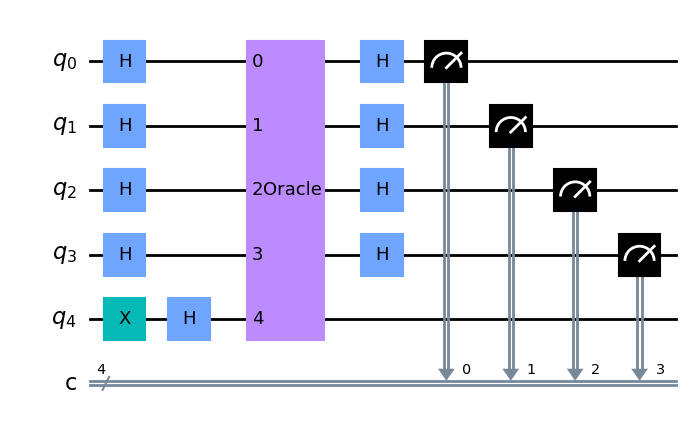

In [3]:
#=============================================================================#
#                               Circuit Plot                                  #
#=============================================================================#
n = 4
dj_circuit = dj_algorithm(n,'balanced')
dj_circuit.draw(output='mpl')

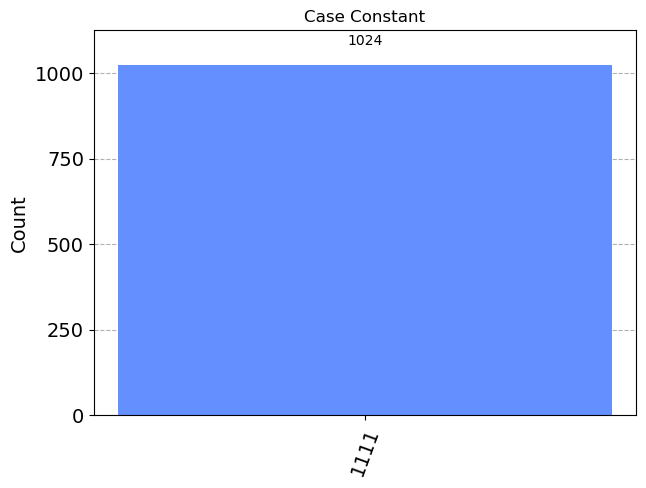

In [5]:
#=============================================================================#
#                Execution in Local Simulator (absense of noise)              #
#=============================================================================#
backend = Aer.get_backend('qasm_simulator')
job = execute(dj_circuit,backend,shots = 1024)
result = job.result()
counts = result.get_counts(dj_circuit)
plot_histogram(counts, title = "Case Constant")#.savefig('Case_Constant.png')


In [6]:
#=============================================================================#
#         Execution in real quantum machine via IBM Quantum Experience        #
#=============================================================================#
# Case Balanced #
#---------------#
backend = least_busy(provider.backends(filters = lambda x: x.configuration().n_qubits >= (n+1) and 
not x.configuration().simulator and x.status().operational == True))

print("least busy backend: ", backend)

dj_circuit = dj_algorithm(n,case = "balanced")
job = execute(dj_circuit,backend=backend,shots = 1024, optimization_level= 3)

least busy backend:  ibmq_quito


In [7]:
# Get the results and plot the histogram
result = job.result()
counts = result.get_counts()
plot_histogram(counts,color='midnightblue', title="Balanced Function")

In [11]:
#=============================================================================#
#         Execution in real quantum machine via IBM Quantum Experience        #
#=============================================================================#
# Case Constant #
#---------------#
backend = least_busy(provider.backends(filters = lambda x: x.configuration().n_qubits >= (n+1) and 
not x.configuration().simulator and x.status().operational == True))

print("least busy backend: ", backend)

dj_circuit = dj_algorithm(n,case = "constant")
job = execute(dj_circuit,backend=backend,shots = 1024, optimization_level= 3)

least busy backend:  ibmq_belem


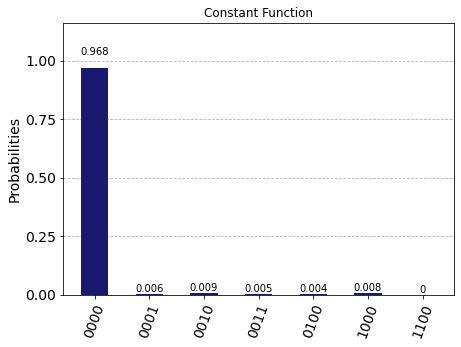

In [13]:
# Get the results and plot the histogram
result = job.result()
counts = result.get_counts()
plot_histogram(counts,color='midnightblue', title="Constant Function")